In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import numpy as np
import os
import matplotlib.pyplot as plt
# import argparse

from resnet import ResNet18
# from utils import progress_bar
from collections import defaultdict
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from pathlib import Path
import json

pd.options.display.float_format = '{:.2f}'.format


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# torch.utils.data.Subset()

cutoff_class = 50

indices_train_1 = [i for i, (x,y) in enumerate(trainset) if y <=cutoff_class]
indices_train_2 = [i for i, (x,y) in enumerate(trainset) if y >cutoff_class]

indices_test_1 = [i for i, (x,y) in enumerate(testset) if y <=cutoff_class]
indices_test_2 = [i for i, (x,y) in enumerate(testset) if y >cutoff_class]

trainset_1, trainset_2 = [
    torch.utils.data.Subset(trainset, inds)
    for inds in [indices_train_1, indices_train_2]
]

testset_1, testset_2 = [
    torch.utils.data.Subset(testset, inds)
    for inds in [indices_test_1, indices_test_2]
]

trainloader_1, trainloader_2, trainloader_12 = [
    torch.utils.data.DataLoader(d, batch_size=128, shuffle=True, num_workers=2)
    for d in [trainset_1, trainset_2, trainset]
]

testloader_1, testloader_2, testloader_12 = [
     torch.utils.data.DataLoader(d, batch_size=100, shuffle=False, num_workers=2)
    for d in [testset_1, testset_2, testset]
]


# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
print('==> Building model..')
# net = VGG('VGG19')
net = ResNet18(num_classes=100, detach_residual=True)
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

==> Building model..


In [5]:
metrics_df = []

In [6]:
def linear_eval(model, train_loader, test_loader, num_ws=5, w_min=-2, w_max=5):
    train_embs = []
    train_targets = []

    test_embs = []
    test_targets = []

    model.eval()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs, return_activations=True)["pool"]
            train_embs.append(outputs)
            train_targets.append(targets)

        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs, return_activations=True)["pool"]
            test_embs.append(outputs)
            test_targets.append(targets)


    train_embs, train_targets, test_embs, test_targets = [
        torch.cat(t)
        for t in [train_embs, train_targets, test_embs, test_targets]
    ]

    # print([t.shape for t in [train_embs, train_targets, test_embs, test_targets]])
    
    def build_step(X, Y, classifier, optimizer, w, criterion_fn):
        def step():
            optimizer.zero_grad()
            loss = criterion_fn(classifier(X), Y, reduction='sum')
            for p in classifier.parameters():
                loss = loss + p.pow(2).sum().mul(w)
            loss.backward()
            return loss
        return step

    best_cls = None
    best_acc = 0
    best_w = 0
    for w in torch.logspace(w_min, w_max, steps=num_ws).tolist():
        classifier_2 = nn.Linear(512, 100).to(device).train()
        optimizer = torch.optim.LBFGS(
            classifier_2.parameters(), 
            line_search_fn='strong_wolfe', max_iter=5000, lr=1, tolerance_grad=1e-10, tolerance_change=0,
        )

        optimizer.step(build_step(train_embs, train_targets, classifier_2, optimizer, w, criterion_fn=torch.nn.functional.cross_entropy))
        classifier_2.eval()
        y_test_pred = classifier_2(test_embs).argmax(dim=1)
        acc = (y_test_pred == test_targets).float().mean().item()

        if acc > best_acc:
            best_acc = acc
            best_cls = classifier_2
            best_w = w
            
    return best_acc


In [7]:
def collapse_metrics(model, loader):
    metrics = dict()
    
    acts = defaultdict(list)
    model.eval()
    for batch_idx, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs, return_activations=True)
        for k,v in outputs.items():
            a = v.detach().cpu().numpy()
            if len(a.shape) == 4:
                a = a.mean(axis=(2,3))
            acts[k].extend(a)
        acts["y_true"].extend(targets.detach().cpu().numpy())

            
    for layer, fts in acts.items():
        fts = np.array(fts)
        
        if layer in ["pool", "out"] or len(fts.shape) == 1:
            continue

        pca = PCA().fit(fts)
        exp_var =  pca.explained_variance_ratio_

        cum = np.cumsum(exp_var)
        for i, c in enumerate(cum):
            if c > 0.9:
                break
        
        metrics[f"exp90/{layer}/all-classes"] = i
        
        ############################
        per_class_cums = []
        per_class_cs = []

        for label in list(set(acts["y_true"])): # todo check all
            index = np.array(acts["y_true"])==label
            c_fts = fts[index]
            pca = PCA().fit(c_fts)
            exp_var =  pca.explained_variance_ratio_

            cum = np.cumsum(exp_var)
            for i, c in enumerate(cum):
                if c > 0.9:
                    break
                    
            metrics[f"exp90/{layer}/{label}"] = i
            
        metrics[f"exp90/{layer}/per-class"] = np.mean([
            v for (k,v) in metrics.items() 
            if (
                ("all" not in k) and 
                (layer in k)
            )
        ])
    
    return metrics
        

In [42]:
exp_id_to_dir = {
    "baseline" : "baseline/",
    "no weight decay": "no_weight_decay/",
    "no gradient through residual": "wd5e-4_detach_residual",
    "entropy loss, lambda=1": "wd_ent_lambda=1",
    "entropy loss, lambda=(-1)": "wd_ent_lambda=-1",
}

loaders = {
    "base 51 classes" : (trainloader_1, testloader_1),
    "new 49 classes": (trainloader_2, testloader_2),
    "all 100 classes": (trainloader_12, testloader_12),
}

In [43]:
# save_dir = "checkpoint/"
# save_dir = "no_weight_decay/"
# save_dir="wd5e-4_detach_residual"

# print(save_dir)

exp_id_to_training_metrics = dict()

metrics_rows = []


for exp_id, directory in exp_id_to_dir.items():
    checkpoint = torch.load(f"{directory}/ckpt.pth")
    net.load_state_dict(checkpoint["net"], strict=True)
    checkpoint["acc"]
    
    training_metrics_json = Path(directory) / "metrics.json"
    
    with training_metrics_json.open("r") as f:
        exp_id_to_training_metrics[exp_id] = json.load(f)
    
    analysis_json = Path(directory) / f"analysis.json"
    
    if analysis_json.exists():
        analysis_rows = []
        
        print(f"found saved analysis for {exp_id}")
        with analysis_json.open("r") as f:
            analysis_rows = json.load(f)
    
    else:
        analysis_rows = []
        for set_name, (trainl, testl) in loaders.items():
            row = {
                "model": exp_id,
                "data": set_name,
            }
            acc = linear_eval(net, trainl, testl)
            print(f"{exp_id}: linear/{set_name}: {acc:.2f}")
            row["linear_eval"] = acc
            collapse = collapse_metrics(net, testl)
            print({k: v for k,v in collapse.items() if any([s in k for s in ["all", "per-class"]])})
            row.update(collapse)
            analysis_rows.append(row)
            
        with analysis_json.open("w") as f:
            json.dump(analysis_rows, f, indent=2)

    metrics_rows.extend(analysis_rows)
    
        
    

found saved analysis for baseline
found saved analysis for no weight decay
found saved analysis for no gradient through residual
found saved analysis for entropy loss, lambda=1
found saved analysis for entropy loss, lambda=(-1)


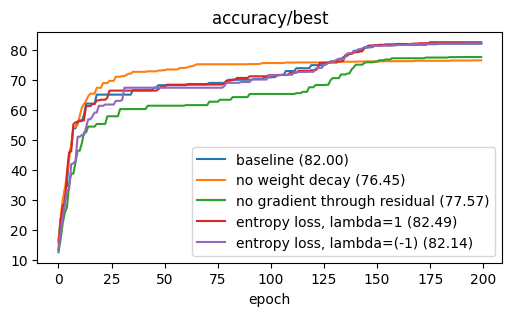

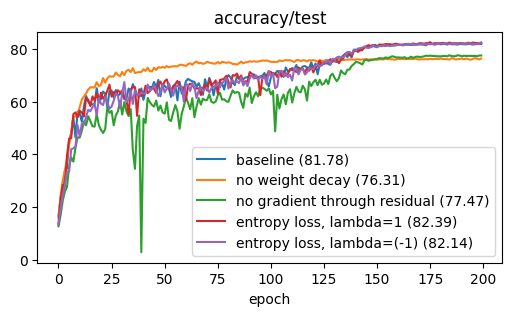

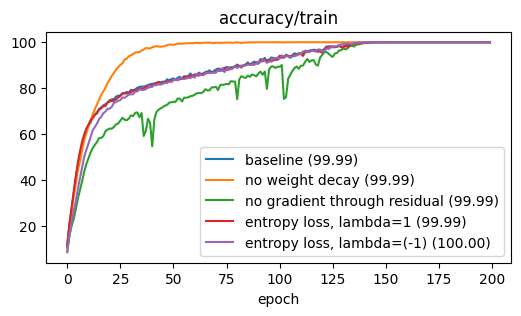

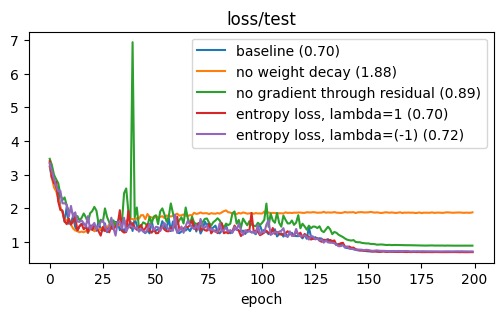

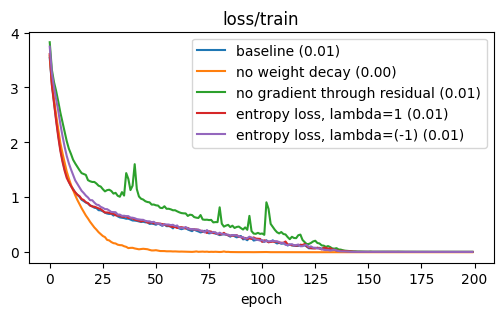

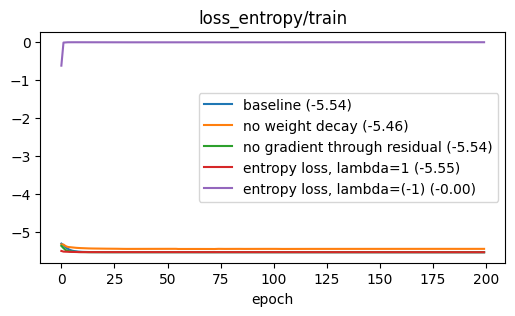

In [44]:
metrics_names = sorted([n for n in list(exp_id_to_training_metrics.values())[0][0].keys() if n != "epoch"])

for n in metrics_names:
    plt.figure(figsize=(6, 3))
    for exp_id, metrics_list in exp_id_to_training_metrics.items():
        plt.plot([m[n] for m in metrics_list], label=f"{exp_id} ({metrics_list[-1][n]:.2f})")
    plt.xlabel("epoch")
    plt.title(n)
    plt.legend()
    plt.show()


In [38]:
df = pd.DataFrame(metrics_rows)

df[[
    c for c in df.columns
    if not (
        c.startswith("exp90")
        and not any([s in c for s in ["all", "per-class"]])
        or c.startswith("exp90/c")
    )
]].set_index(['model', "data"])

linear_eval  \
model                        data                           
baseline                     base 51 classes         0.82   
                             new 49 classes          0.62   
                             all 100 classes         0.57   
no weight decay              base 51 classes         0.76   
                             new 49 classes          0.63   
                             all 100 classes         0.60   
no gradient through residual base 51 classes         0.77   
                             new 49 classes          0.56   
                             all 100 classes         0.52   
entropy loss, lambda=1       base 51 classes         0.82   
                             new 49 classes          0.62   
                             all 100 classes         0.58   
entropy loss, lambda=(-1)    base 51 classes         0.82   
                             new 49 classes          0.61   
                             all 100 classes         0.57   

                                              exp90/l1/all-classes  \
model                        data                                    
baseline                     base 51 classes                     8   
                             new 49 classes                      8   
                             all 100 classes                     8   
no weight decay              base 51 classes                     8   
                             new 49 classes                      7   
                             all 100 classes                     8   
no gradient through residual base 51 classes                     3   
                             new 49 classes                      3   
                             all 100 classes                     3   
entropy loss, lambda=1       base 51 classes                     6   
                             new 49 classes                      6   
                             all 100 classes                     6   
entropy loss, lambda=(-1)    base 51 classes                     8   
                             new 49 classes                      8   
                             all 100 classes                     8   

                                              exp90/l1/per-class  \
model                        data                                  
baseline                     base 51 classes                6.41   
                             new 49 classes                 6.24   
                             all 100 classes                6.33   
no weight decay              base 51 classes                6.22   
                             new 49 classes                 6.27   
                             all 100 classes                6.24   
no gradient through residual base 51 classes                2.24   
                             new 49 classes                 2.37   
                             all 100 classes                2.30   
entropy loss, lambda=1       base 51 classes                5.24   
                             new 49 classes                 5.29   
                             all 100 classes                5.26   
entropy loss, lambda=(-1)    base 51 classes                6.47   
                             new 49 classes                 6.31   
                             all 100 classes                6.39   

                                              exp90/l2/all-classes  \
model                        data                                    
baseline                     base 51 classes                    20   
                             new 49 classes                     19   
                             all 100 classes                    20   
no weight decay              base 51 classes                    15   
                             new 49 classes                     15   
                             all 100 classes                    15   
no gradient through residual base 51 classes                     9   
                             n